# Example 1: Regular Denoiser


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

# Updated imports for new modular pipeline
from xasdenoise.xas_data import data_io, visualization
from xasdenoise.denoising_methods.denoisers import RegularDenoiser  # Updated path
from xasdenoise.denoising_pipeline import PipelineConfig, DenoisingPipeline  # New modular pipeline

# Set global font size for all plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 18})  # Update the default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Update the default font size for axes titles
plt.rcParams.update({'axes.labelsize': 18})  # Update the default font size for axes labels
plt.rcParams.update({'xtick.labelsize': 18})  # Update the default font size for x tick labels
plt.rcParams.update({'ytick.labelsize': 18})  # Update the default font size for y tick labels

## Load Sample Data

Load a sample XAS spectrum for demonstration.

Loaded None spectrum.
Loaded 1 spectra from ./data/processed_spectrum.h5


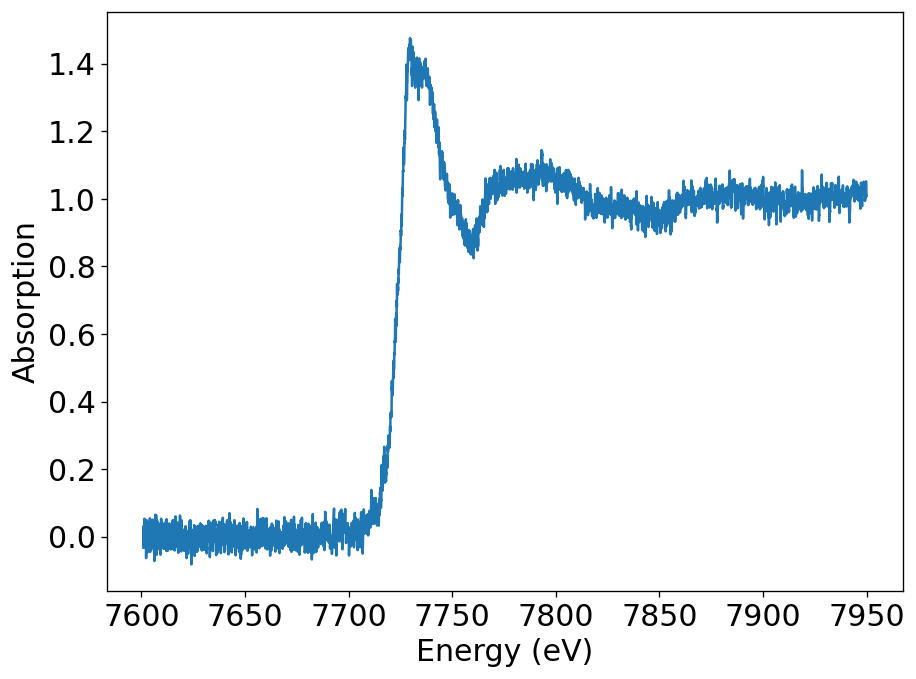

In [2]:
# Load the data from a CSV file
# import pandas as pd
# import numpy as np
# from xasdenoise.xas_data.spectrum import Spectrum
# folder_path = './data/processed_spectrum.csv'
# csv_file = pd.read_csv(folder_path)
# energy = csv_file.iloc[:, 0].values
# mu = csv_file.iloc[:, 1].values
# spectrum0 = Spectrum(energy=energy, spectrum=mu[:, np.newaxis])

# Load the Spectrum object from an h5 file
spectrum0 = data_io.load_spectra_from_h5('./data/processed_spectrum.h5')

# Visualize
visualization.plot_spectrum(spectrum0)

# Basic denoising
The denoising pipeline consists of multiple steps such as edge-step estimation, noise estimation, data warping etc. Here we will write a function for the most basic implementation of the denoising pipeline using basic default parameters.

There are three main classes required by the denoising pipeline:
- PipelineConfig() - class which defines a large list of denoising pipeline parameters.
- Denoiser() - class which defines which denoiser to use. At the moment there are three classed RegularDenoiser, EncoderDenoiser, GPDenoiser.
- DenoisingPipeline() - class which takes in the Config and the Denoiser classes and performs various data pre-processing and denoising steps.


The simplest denoising implementation using basic default parameters. The resulting denoising looks noisy, since the denoiser parameter is not set correctly.

Denoising using method butterworth, with the following parameters
  order: 3
  cutoff: 0.05
============= Starting XAS Denoising Pipeline =============
--------------- Data Preprocessing ---------------
Estimating baseline using method: step


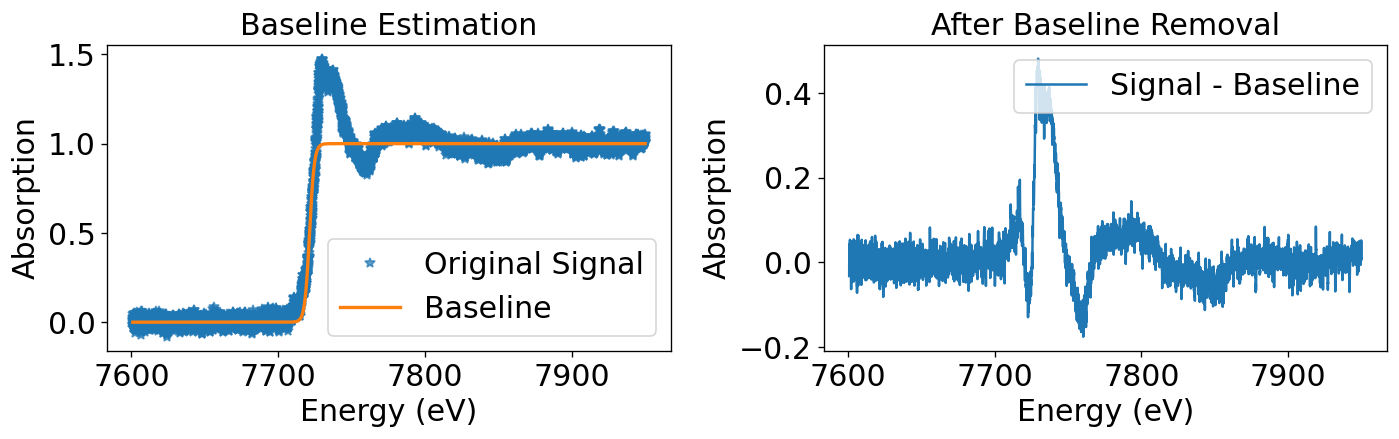

Estimating noise level


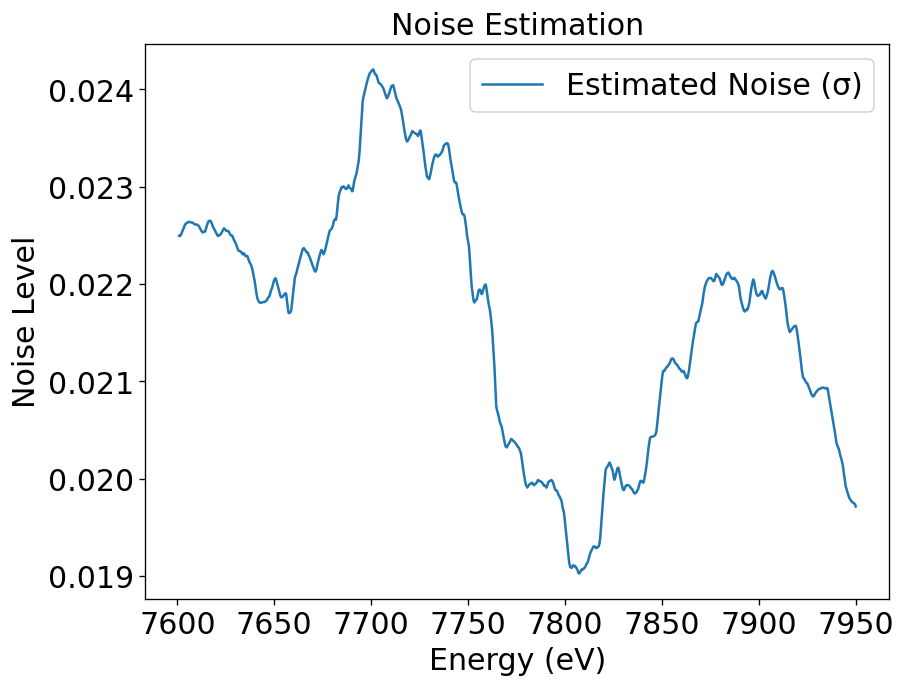

--------------- Data Warping ---------------
--------------- Data Denoising ---------------
Applying standard denoising
--------------- Post-processing ---------------
Restoring baseline and scaling
Post-processing complete.
============= Pipeline Complete =============


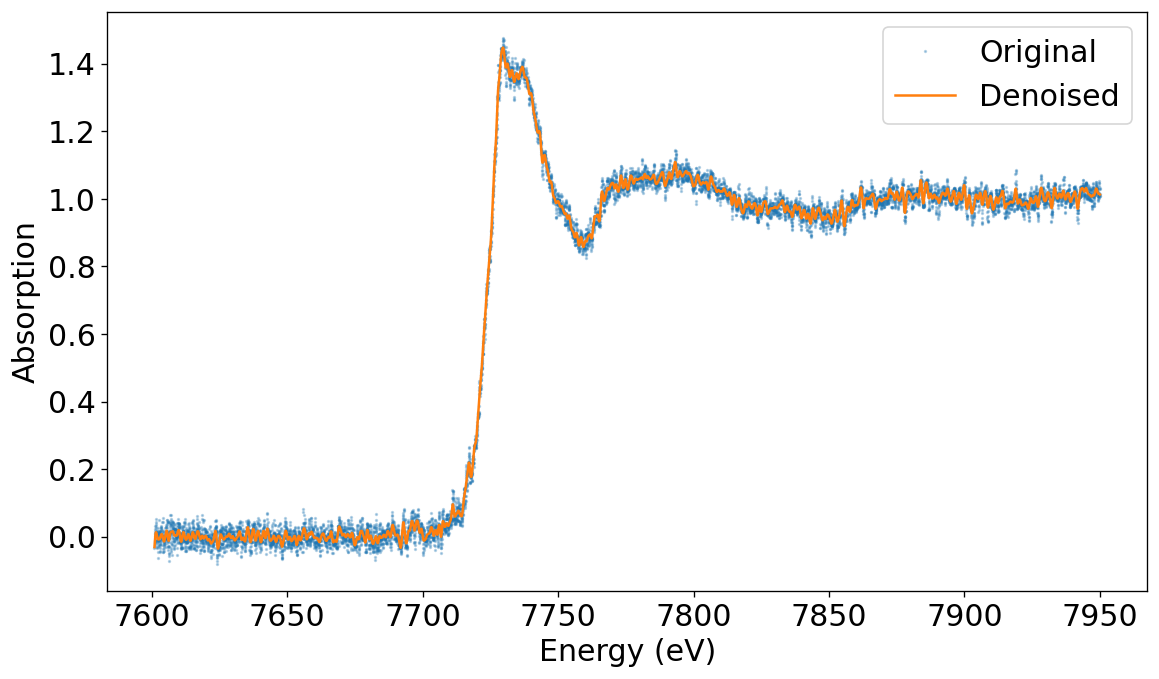

Denoising completed!


In [3]:
def simple_denoising(spectrum_obj):
    """
    Simple denoising using the denoising pipeline.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=2,
        data_baseline_removal='step'  # Optional: remove baseline
    )
    
    # Create denoiser
    denoiser = RegularDenoiser('butterworth', cutoff=0.05)
    
    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj)

print(f"Denoising completed!")

# Optimization of denoising parameters
To avoid manual parameter fine-tuning we can estimate the parameters automatically. This allows fine-tuning only a single parameter called "lambda" which affects the total variation optimization strength. The benefit of this approach is that irrespective of the denoising method used, only a single parameter needs to be tuned, without the need to understand what are the sensible values for each individual denoising method.

The parameter that must be tuned is part of the denoising pipeline:
- denoiser.optimize_params_tv_lambda = 1e-3

The optimization leads to a an optimal cutoff parameter selection which leads to a smoother signal with all of the features still present. Adjustment of "optimize_params_tv_lambda" controls the smoothing strength.


Denoising using method butterworth, with the following parameters
  order: 3
  cutoff: 0.05
============= Starting XAS Denoising Pipeline =============
--------------- Data Preprocessing ---------------
Estimating baseline using method: step
Estimating noise level
--------------- Data Warping ---------------
--------------- Data Denoising ---------------
Applying standard denoising
Denoising using method: butterworth.
Optimizing parameter: cutoff = 0.05 with bounds [0.01, 0.5]
Initializing with grid search...
Fine-tuning with gradient descent...
Optimized parameter: cutoff = 0.01. Took 10 iterations out of 100.
--------------- Post-processing ---------------
Restoring baseline and scaling
Post-processing complete.
============= Pipeline Complete =============


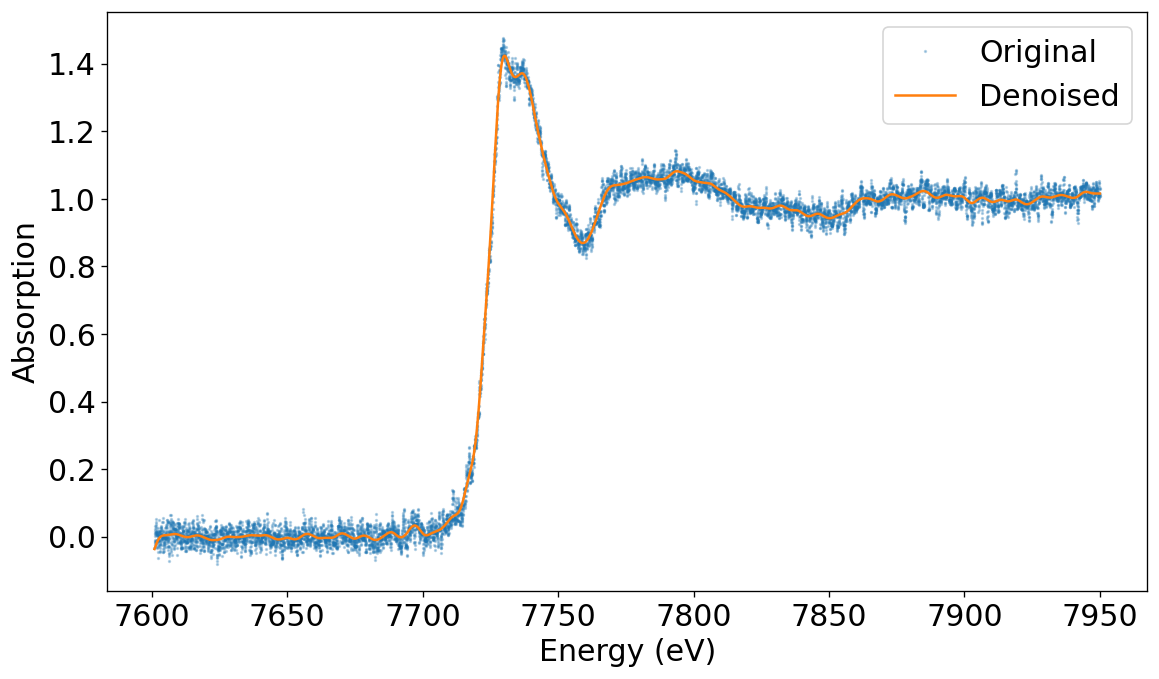

Denoising completed!


In [4]:
def simple_denoising(spectrum_obj):
    """
    Simple denoising using the denoising pipeline.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=1,
        data_baseline_removal='step'  # Optional: remove baseline
    )
    
    # Create denoiser
    denoiser = RegularDenoiser('butterworth', cutoff=0.05)
    denoiser.verbose = 1
    
    # Turn on denoiser parameter optimization
    denoiser.optimize_params_flag = True
    denoiser.optimize_params_tv_lambda = 1e-2
    denoiser.optimize_params_scale_tv_lambda_by_noise = True # scale TV lambda by noise level
    denoiser.optimize_params_method = 'gradient_descent' # 'grid_search' or 'gradient_descent'

    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj)

print(f"Denoising completed!")

# Perform data warping
There are multiple ways to perform data warping, which has been shown to improve data denoising performance when dealing with non-stationary data (most XAS spectra). With warping the spectrum is transformed into a domain where the data appears more stationary and results in improved denoising performance.

To enable data warping we need to set the "config.input_warping_method" from None, to one of the warping methods:
- config.input_warping_method = 'kspace' # 'kspace', 'smoothness' or 'kspace_exafs_smoothness_xanes'

In addition to warping we also need the data to be interpolated onto a uniform warped grid when using GeneralDenoising class, because these denoising methods assume that the data is uniformly sampled. The following parameter is used:
- config.warping_interpolation_method = 'downsample' # 'same', 'upsampled', 'optimized'

Downsampling method avoids interpolation artefacts and maximally utilizes the data when interpolating onto a unified grid.

For k-space warping we need to select a specific energy which corresponds to the zeroth k-space value. This energy value can be set manually using:
- config.warping_energy = 100 # eV

By default (if set to None), the value will be set as the middle of the absorption edge step function.


Denoising using method butterworth, with the following parameters
  order: 3
  cutoff: 0.05
============= Starting XAS Denoising Pipeline =============
--------------- Data Preprocessing ---------------
Estimating baseline using method: step


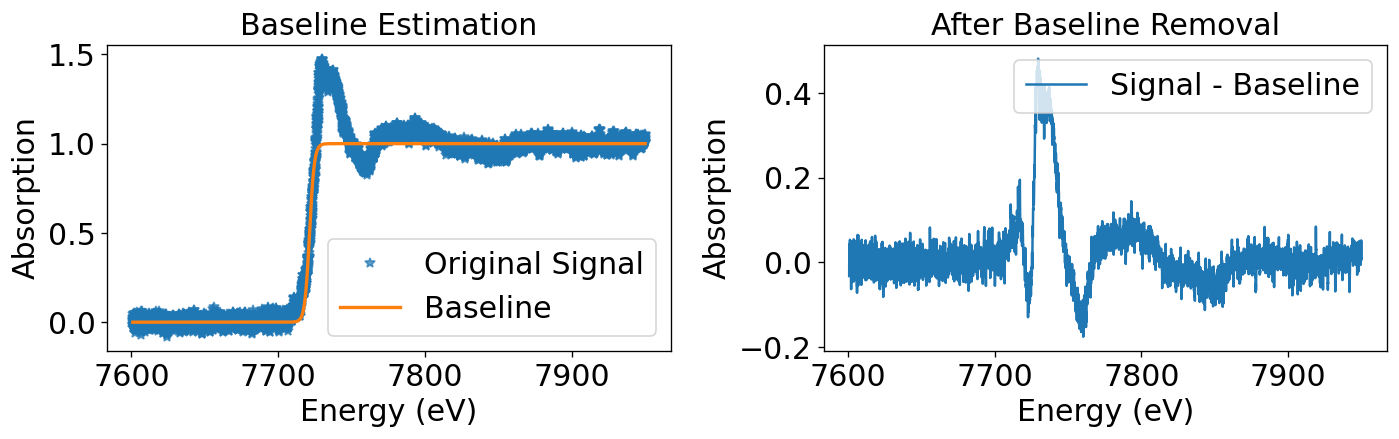

Estimating noise level


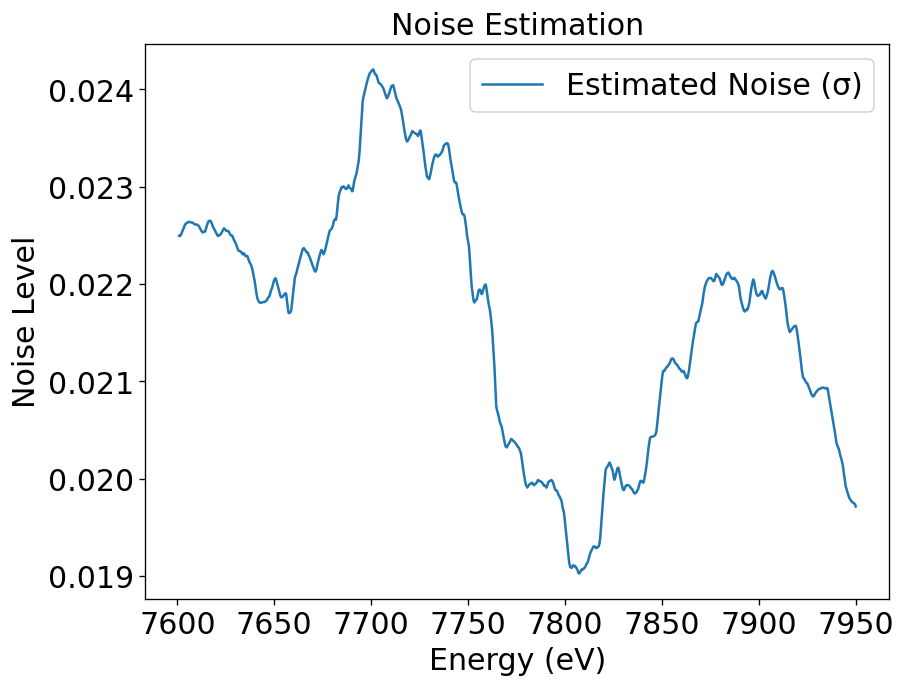

--------------- Data Warping ---------------
Applying kspace warping


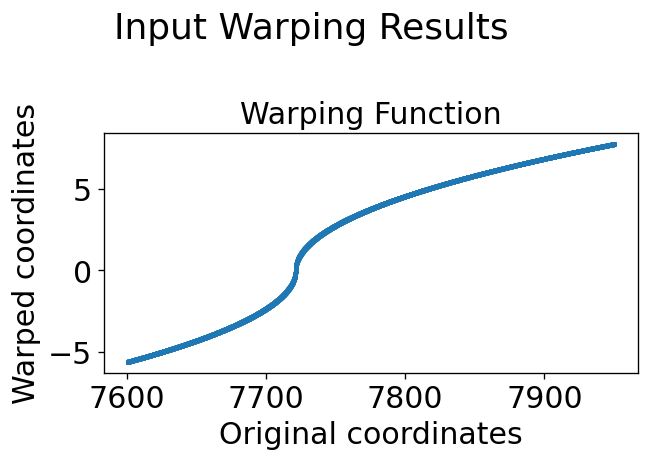

Input warping initialized using 'kspace' method
Original x range: [7600.9843, 7949.9988]
Warped x range: [-5.6216, 7.7469]


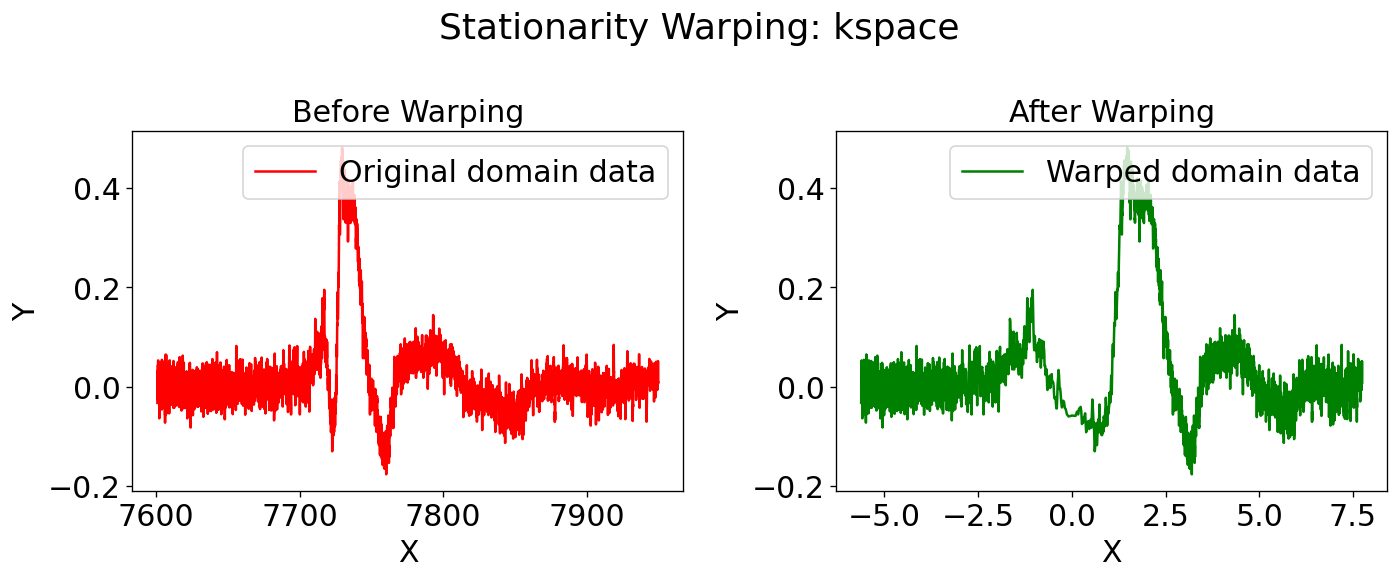

Interpolation initialized using 'downsample' method
Input grid points: 9999
Output grid points: 6348
Grid range: [-5.6216, 7.7469]


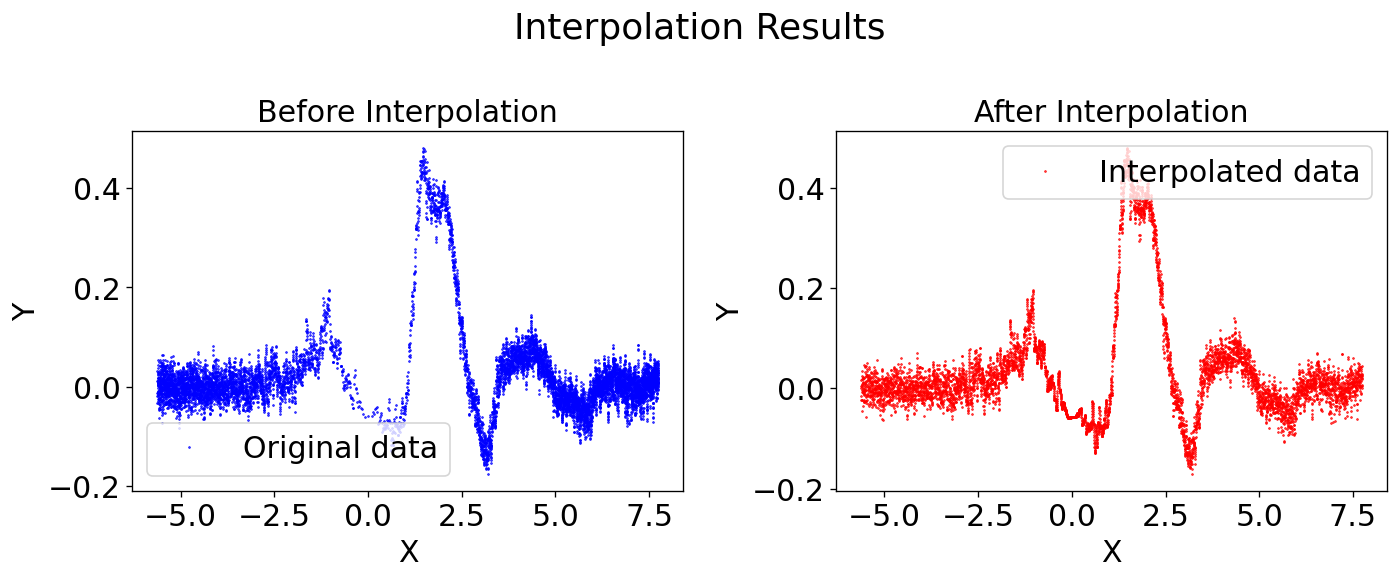

Warped grid: 9999 -> 6348 points
--------------- Data Denoising ---------------
Applying standard denoising
Denoising using method: butterworth.
Optimizing parameter: cutoff = 0.05 with bounds [0.01, 0.5]
Initializing with grid search...
Fine-tuning with gradient descent...
Optimized parameter: cutoff = 0.01. Took 10 iterations out of 100.
--------------- Post-processing ---------------
Unwarping data back to original domain
Undoing warping transformation


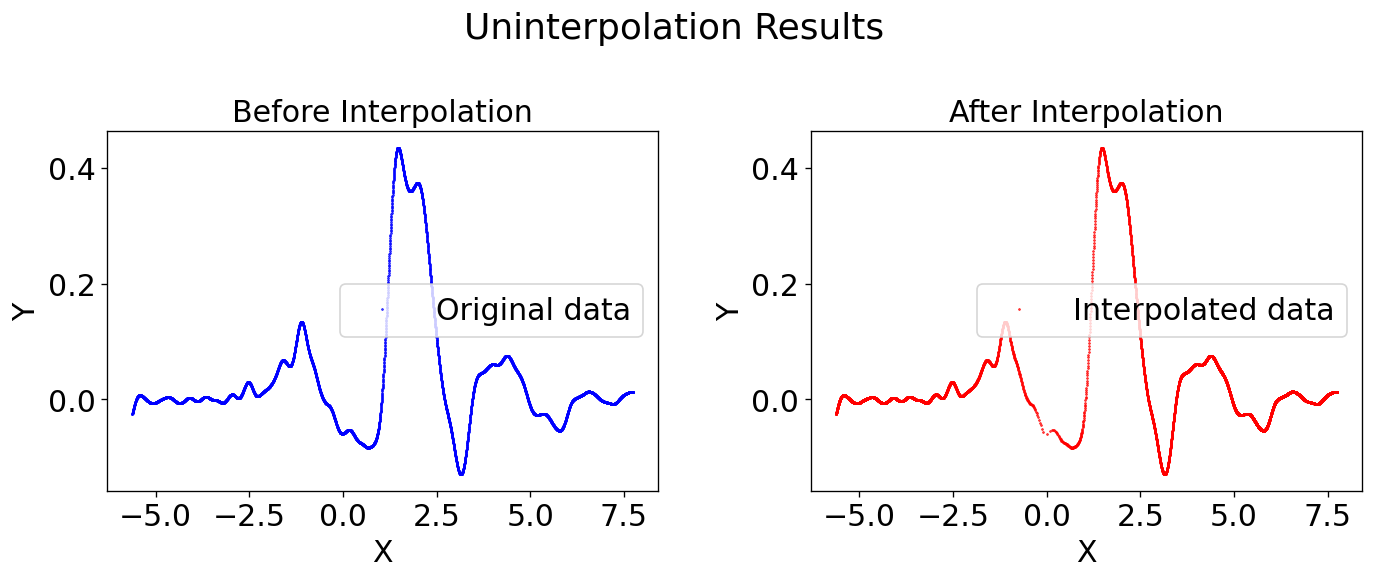

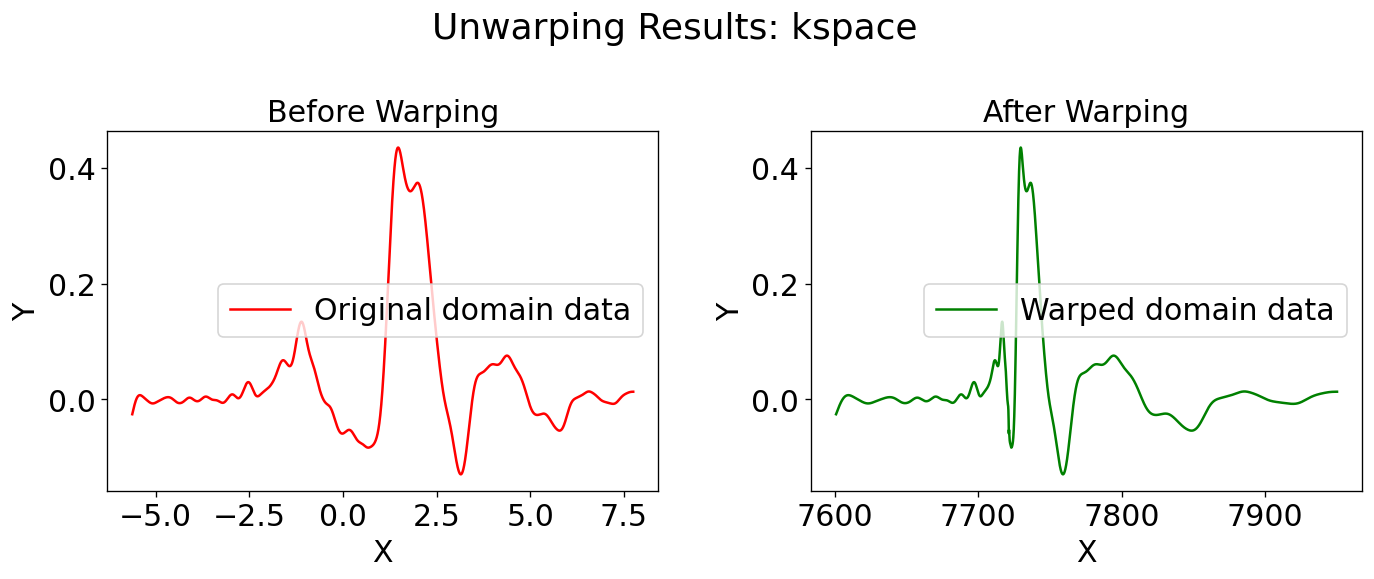

Restoring baseline and scaling
Post-processing complete.
============= Pipeline Complete =============


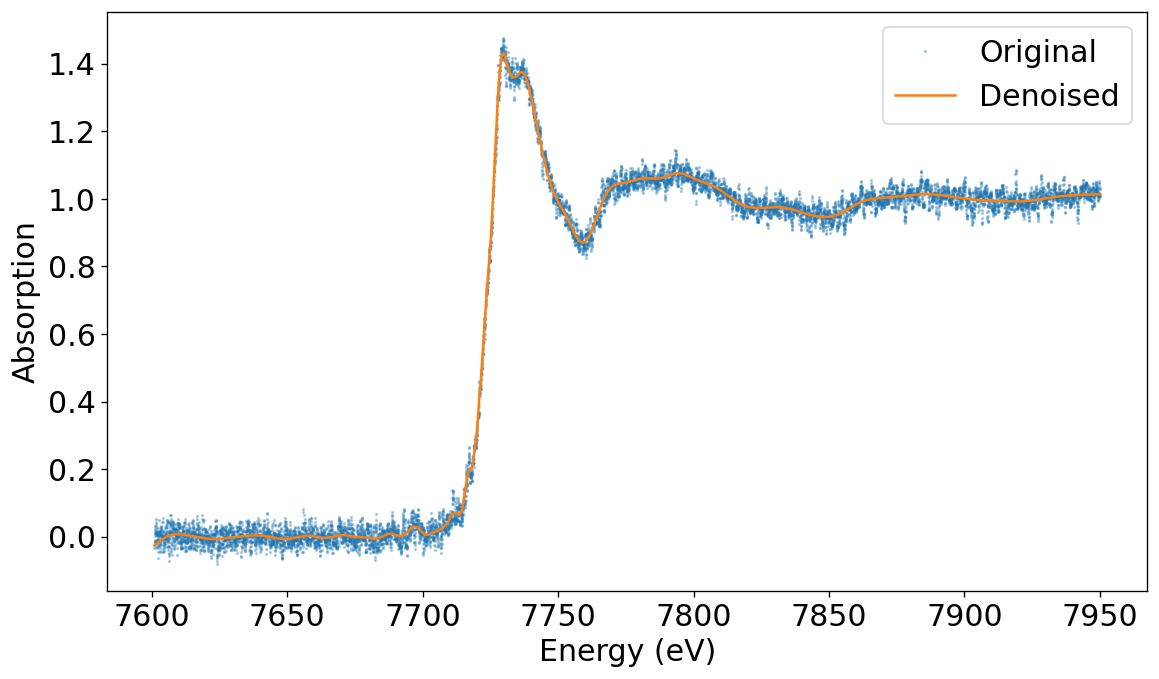

Denoising completed!


In [5]:
def simple_denoising(spectrum_obj):
    """
    Simple denoising using the denoising pipeline.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=2,
        data_baseline_removal='step'  # Optional: remove baseline
    )
    
    # Warping parameters
    config.input_warping_method = 'kspace' # 'kspace', 'smoothness' or 'kspace_exafs_smoothness_xanes'
    config.warping_interpolation_method = 'downsample'  
      
    # Create denoiser
    denoiser = RegularDenoiser('butterworth', cutoff=0.05)
    denoiser.verbose = 1
    
    # Turn on denoiser parameter optimization
    denoiser.optimize_params_flag = True
    denoiser.optimize_params_tv_lambda = 1e-2
    denoiser.optimize_params_scale_tv_lambda_by_noise = True # scale TV lambda by noise level
    denoiser.optimize_params_method = 'gradient_descent' # 'grid_search' or 'gradient_descent'

    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj)

print(f"Denoising completed!")

# Denoising XANES and EXAFS regions separately
Another way to denoise XAS signals is to denoise the pre and post edge regions separately, since both regions have different characteristics that can benefit from different signal denoising paramters. To do this, set:
- "config.split_xanes_exafs = True"

We can see below that each region got different denoising parameters for the butterworth filters, during denoiser parameter optimization.

The energy that defines the boundary between XANES and EXAFS signals can be set via
- config.split_xanes_exafs_energy = None 

If the default value of None is used, then the middle of the edge step is used.

Denoising using method butterworth, with the following parameters
  order: 3
  cutoff: 0.05
============= Starting XAS Denoising Pipeline =============
--------------- Data Preprocessing ---------------
Estimating baseline using method: step_not_normalized


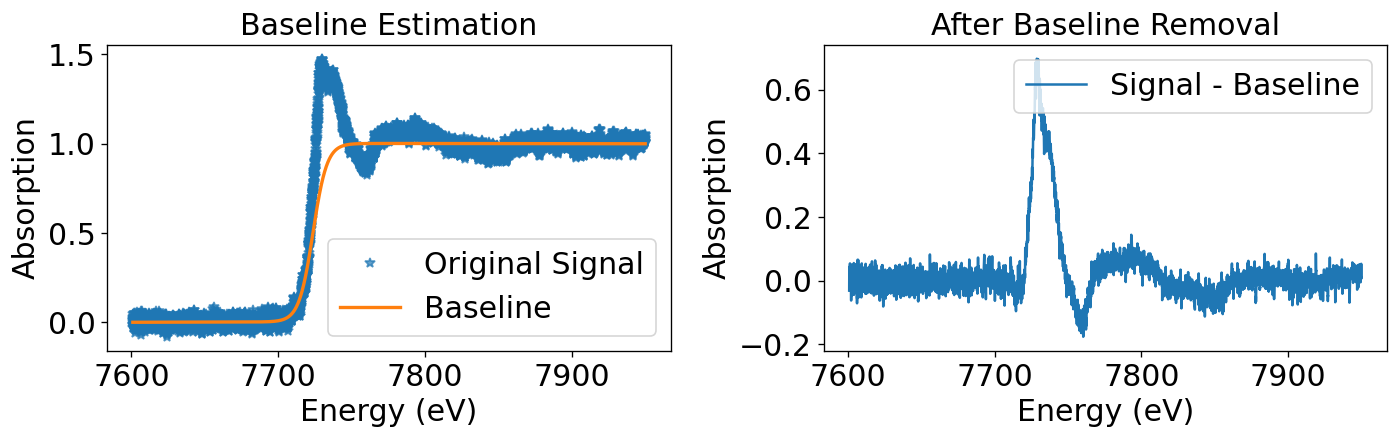

Estimating noise level


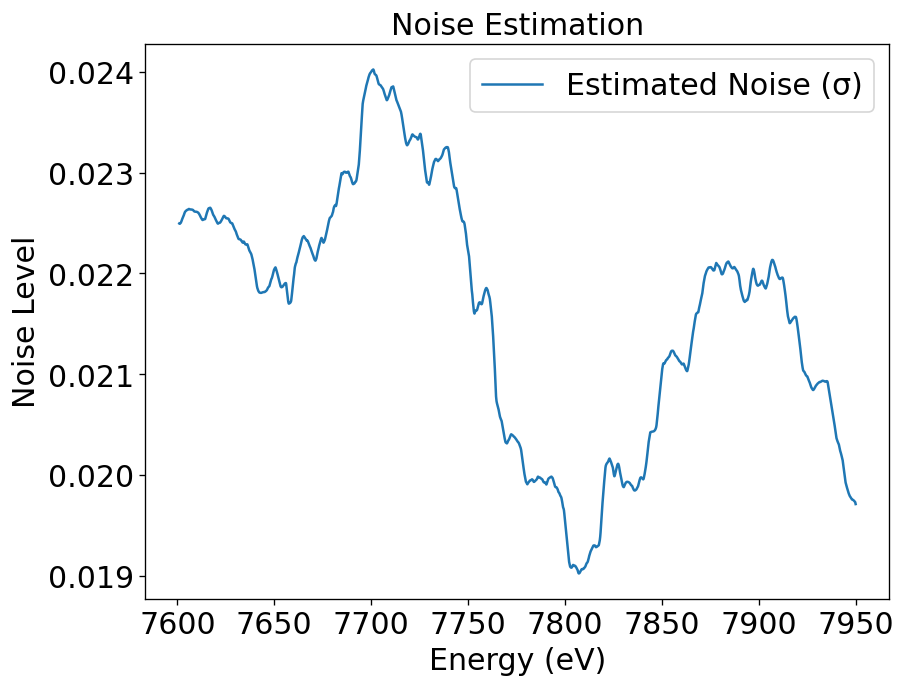

--------------- Data Warping ---------------
--------------- Data Denoising ---------------
Denoising with XANES/EXAFS region splitting
Processing XANES region: 3634 points
Denoising using method: butterworth.
Optimizing parameter: cutoff = 0.05 with bounds [0.01, 0.5]
Initializing with grid search...
Fine-tuning with gradient descent...
Optimized parameter: cutoff = 0.02285235992840365. Took 100 iterations out of 100.
Processing EXAFS region: 6365 points
Denoising using method: butterworth.
Optimizing parameter: cutoff = 0.02285235992840365 with bounds [0.01, 0.5]
Initializing with grid search...
Fine-tuning with gradient descent...
Optimized parameter: cutoff = 0.01. Took 10 iterations out of 100.
--------------- Post-processing ---------------
Restoring baseline and scaling
Post-processing complete.
============= Pipeline Complete =============


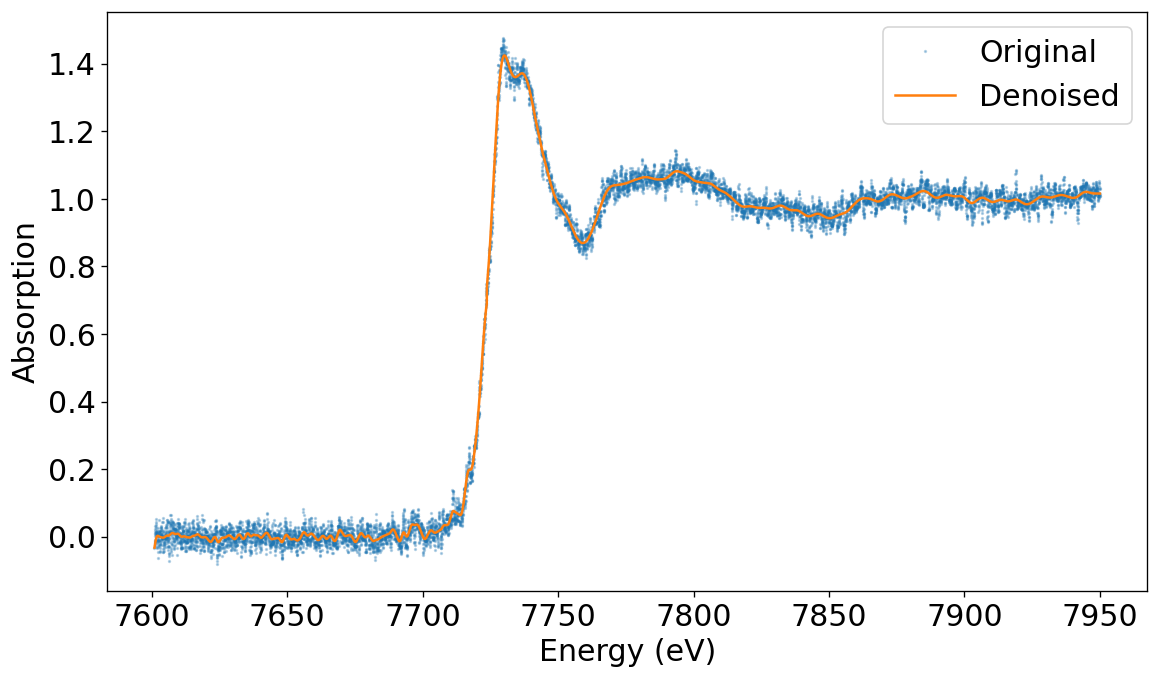

Denoising completed!


In [6]:
def simple_denoising(spectrum_obj):
    """
    Simple denoising using the denoising pipeline.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=2,
        data_baseline_removal='step_not_normalized'  # Optional: remove baseline
    )
    
    # Denoise the XANES and EXAFS regions separately
    config.split_xanes_exafs = True 
    config.split_xanes_exafs_energy = None # None means the middle of the edge step is used to split the regions

    # Create denoiser
    denoiser = RegularDenoiser('butterworth', cutoff=0.05)
    denoiser.verbose = 1
    
    # Turn on denoiser parameter optimization
    denoiser.optimize_params_flag = True
    denoiser.optimize_params_tv_lambda = 1e-2
    denoiser.optimize_params_scale_tv_lambda_by_noise = True # scale TV lambda by noise level
    denoiser.optimize_params_method = 'gradient_descent' # 'grid_search' or 'gradient_descent'

    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    pipeline.plot_results(fig_size=(10, 6))
    return y_denoised, y_error, y_noise

# Run denoising
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj)

print(f"Denoising completed!")